In [1]:
import sys
sys.path.append('../code')

import pdb
import numpy as np
import tensorflow as tf
import gpflow

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn')

from pathlib import Path
from gpflow.likelihoods import Gaussian
from gpflow.kernels import SquaredExponential, White
from gpflow.optimizers import Scipy
from gpflow.utilities import print_summary, triangular
from gpflow.base import Parameter

from dgp import DGP

gpflow.config.set_default_summary_fmt('notebook')
np.random.seed(0)
tf.random.set_seed(0)

In [2]:
output_logdir = '/tmp/tensorboard'

!rm -rf '{output_logdir}'
!mkdir '{output_logdir}'

%load_ext tensorboard

def enumerated_logdir(_logdir_id: int = [0]):
    logdir = Path(output_logdir, str(_logdir_id[0]))
    _logdir_id[0] += 1
    return str(logdir)

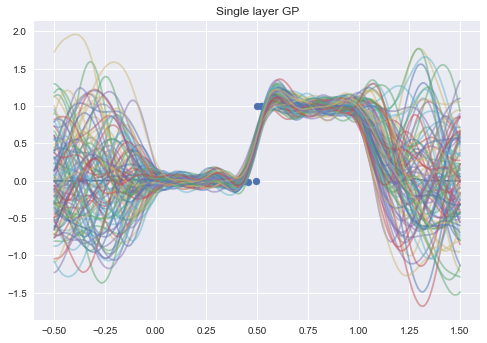

In [35]:
Ns = 300
Xs = np.linspace(-0.5, 1.5, Ns)[:, None]

N, M = 50, 25
X = np.random.uniform(0, 1, N)[:, None]
Z = np.random.uniform(0, 1, M)[:, None]
f_step = lambda x: 0. if x<0.5 else 1.
Y = np.reshape([f_step(x) for x in X], X.shape)\
    + np.random.randn(*X.shape) * 1e-2

def train_and_plot_gp(X, Y, kernel):
    m_gp = gpflow.models.GPR(data=(X, Y), kernel=kernel)
    opt = Scipy()
    
    def loss_func():
        return - m_gp.log_marginal_likelihood()
    
    opt_logs = opt.minimize(loss_func, m_gp.trainable_variables)
    m, v = m_gp.predict_y(Xs)
    samples = m_gp.predict_f_samples(Xs, 100)
    m, v = m.numpy(), v.numpy()
    plt.plot(Xs, m)
    l = (m - 2 * v ** 0.5).flatten()
    u = (m + 2 * v ** 0.5).flatten()
    plt.plot(Xs, tf.transpose(samples[:, :, 0]), alpha=0.5)
#     plt.fill_between(Xs.flatten(), l, u, alpha=0.2)
    plt.title('Single layer GP')
    plt.scatter(X, Y)
    plt.show()
    
    return opt_logs

opt_logs = train_and_plot_gp(X, Y, SquaredExponential())

In [4]:
def make_DGP(L):
    kernels = []
    for l in range(L):
        k = SquaredExponential(variance=1, lengthscale=0.2)\
            + White(variance=1e-5)
        kernels.append(k)
        
    m_dgp = DGP(X.shape[1], kernels, Gaussian(), Z, num_outputs=Y.shape[1],
                num_samples=100)
    
#     Initialise the layers to near deterministic
    for layer in m_dgp.layers[:-1]:
        layer.q_sqrt = Parameter(layer.q_sqrt.value() * 1e-5, 
                                 transform=triangular())
        
    return m_dgp

dgp = make_DGP(2)

In [5]:
optimiser = tf.optimizers.Adam(0.01)

def optimisation_step(model):
    with tf.GradientTape() as tape:
        tape.watch(model.trainable_variables)
        obj = - model.elbo(X, Y, full_cov=False)
        grad = tape.gradient(obj, model.trainable_variables)
    optimiser.apply_gradients(zip(grad, model.trainable_variables))
    
def monitored_training_loop(model, logdir,
                            epochs=1, logging_epoch_freq=10):
    summary_writer = tf.summary.create_file_writer(logdir)
    tf_optimisation_step = tf.function(optimisation_step)
#     tf_optimisation_step = optimisation_step
    
    with summary_writer.as_default():
        for epoch in range(epochs):
            
            tf_optimisation_step(model)
                
            epoch_id = epoch + 1
            if epoch_id % logging_epoch_freq == 0:
                tf.print(f'Epoch {epoch_id}: ELBO (train) {model.elbo(X, Y)}')
                
                # computes the mean and variance of the help-out data at 
                # input points
#                 mean, var = model.predict_f_full_cov(Xs, num_samples=10)
                # produces samples from the posterior at input points
#                 samples, _, _ = model.predict_all_layers_full_cov(Xs, num_samples=10)
#                 fig = plotting_regression(X, Y, Xs, mean, var, samples)
                
#                 summary_matplotlib_image(dict(model_samples=fig), step=epoch)
                tf.summary.scalar('elbo', data=model.elbo(X, Y), step=epoch)
                tf.summary.scalar('likelihood/variance', data=model.likelihood.variance, step=epoch)
                tf.summary.scalar('layer1_kernel/lengthscale', data=model.layers[0].kernel.kernels[0].lengthscale, step=epoch)
                tf.summary.scalar('layer1_kernel/variance', data=model.layers[0].kernel.kernels[0].variance, step=epoch)
                tf.summary.scalar('layer2_kernel/lengthscale', data=model.layers[1].kernel.kernels[0].lengthscale, step=epoch)
                tf.summary.scalar('layer2_kernel/variance', data=model.layers[1].kernel.kernels[0].variance, step=epoch)

In [27]:
monitored_training_loop(dgp, logdir=enumerated_logdir(), 
                        epochs=5000, logging_epoch_freq=200)

Epoch 200: ELBO (train) 99.87903398533139
Epoch 400: ELBO (train) 100.99286479333921
Epoch 600: ELBO (train) 102.69880545468465
Epoch 800: ELBO (train) 103.5540868752038
Epoch 1000: ELBO (train) 105.16323693669867
Epoch 1200: ELBO (train) 106.40954045769928
Epoch 1400: ELBO (train) 108.28924928745587
Epoch 1600: ELBO (train) 108.04889395438434
Epoch 1800: ELBO (train) 110.69020477711953
Epoch 2000: ELBO (train) 111.29099101069177
Epoch 2200: ELBO (train) 113.42825804012998
Epoch 2400: ELBO (train) 113.58540841017299
Epoch 2600: ELBO (train) 115.8031417581868
Epoch 2800: ELBO (train) 114.73782949111356
Epoch 3000: ELBO (train) 117.86093387687094
Epoch 3200: ELBO (train) 117.10174973448756
Epoch 3400: ELBO (train) 119.95504314726685
Epoch 3600: ELBO (train) 117.47593630563799
Epoch 3800: ELBO (train) 119.09481269717608
Epoch 4000: ELBO (train) 120.61495767984624
Epoch 4200: ELBO (train) 120.94293561677708
Epoch 4400: ELBO (train) 120.5891087927036
Epoch 4600: ELBO (train) 119.08757200090

In [28]:
samples, _, _ = dgp.predict_all_layers(Xs, 100, full_cov=True)

# F_mean, F_var = dgp.predict_f(Xs, 10, full_cov=False)

# print(samples[-1].shape)
# print(F_mean.shape)

# m = np.mean(F_mean, axis=0)
# v = np.mean(F_var, axis=0)

# l = (m - 2 * v ** 0.5).flatten()
# u = (m + 2 * v ** 0.5).flatten()

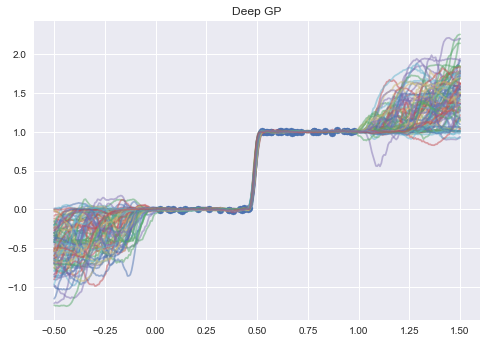

In [29]:
fig, ax = plt.subplots()

ax.plot(Xs, tf.transpose(samples[-1][:, :, 0]), alpha=0.5)
# ax.fill_between(Xs.flatten(), l, u, alpha=0.2)
ax.scatter(X, Y)
plt.title('Deep GP')
plt.show()